## Read the input data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys

from utils.utils import read_ogt_data

# SPECIFY THE DESIRED TAXONOMY SPLIT LEVEL HERE!
TAX_LEVEL = "random" # <----------------- taxonomy level for train/test split is here!!
DATA_DIRECTORY = "data_ogt" # <-------- input data directory is here!!

RANDOM_SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIRECTORY = f"../data_ogt/plots_{TAX_LEVEL}_tax_level"

# Read train data
data_filename_train = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_data_{TAX_LEVEL}_tax_level"
y_filename_train = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_train = None#f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_taxa_names_{TAX_LEVEL}_tax_level"
X_train, y_train, X_column_names, taxa_group_names_train = read_ogt_data(data_filename_train, y_filename_train, taxa_names_filename_train, DEVICE)

# Read test data
data_filename_test = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_data_{TAX_LEVEL}_tax_level"
y_filename_test = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_test = None#f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_taxa_names_{TAX_LEVEL}_tax_level"
X_test, y_test, X_column_names, taxa_group_names_test = read_ogt_data(data_filename_test, y_filename_test, taxa_names_filename_test, DEVICE)

print(f"Number of samples train = {len(X_train)}, number of features = {len(X_column_names)}")
print(f"Number of samples = {len(X_test)}, number of features = {len(X_column_names)}")

Number of samples train = 3002, number of features = 3165
Number of samples = 750, number of features = 3165


In [2]:
import torch
import numpy as np

def downsample_histogram_bins(X, y, num_bins=50, max_count=50, seed=42):
    y_np = y.cpu().numpy()
    X_np = X.cpu().numpy()

    # Create histogram
    counts, bin_edges = np.histogram(y_np, bins=num_bins)
    bin_indices = np.digitize(y_np, bin_edges) - 1

    # Collect indices to keep
    selected_indices = []

    rng = np.random.default_rng(seed)

    for bin_idx in range(num_bins):
        idx_in_bin = np.where(bin_indices == bin_idx)[0]
        if len(idx_in_bin) > max_count:
            sampled = rng.choice(idx_in_bin, size=max_count, replace=False)
        else:
            sampled = idx_in_bin
        selected_indices.extend(sampled)

    selected_indices = np.array(selected_indices)

    # Convert back to torch tensors
    X_filtered = torch.tensor(X_np[selected_indices], device=X.device)
    y_filtered = torch.tensor(y_np[selected_indices], device=y.device)

    return X_filtered, y_filtered

# Example usage
X_train, y_train = downsample_histogram_bins(X_train.cpu(), y_train.cpu().squeeze(), num_bins=30, max_count=40)
#X_test, y_test = downsample_histogram_bins(X_test.cpu(), y_test.cpu().squeeze(), num_bins=30, max_count=40)


In [3]:
mean_train = np.mean(y_train.cpu().squeeze().numpy())
mean_test = np.mean(y_test.cpu().squeeze().numpy())

print(f"Average OGT of the train set = {mean_train}")
print(f"Average OGT of the train set = {mean_test}")

Average OGT of the train set = 44.83812713623047
Average OGT of the train set = 34.09231185913086


In [4]:
# Downsampling

# Example range
r1, r2 = 20.0, 38.0

# Suppose y_train is a NumPy array
mask_in_range = (y_train.squeeze() >= r1) & (y_train.squeeze() <= r2)
mask_in_range_test = (y_test.squeeze() >= r1) & (y_test.squeeze() <= r2)
print(len(y_train))
mask_out_range = ~mask_in_range
mask_out_range_test = ~mask_in_range_test

# Indices of samples within the range
in_range_indices = np.where(mask_in_range.cpu())[0]
in_range_indices_test = np.where(mask_in_range_test.cpu())[0]

# Set the fraction to keep
keep_fraction = 0.3  # keep 50% of values in the range
num_to_keep = int(keep_fraction * len(in_range_indices))
num_to_keep_test = int(keep_fraction * len(in_range_indices_test))

# Randomly select indices to keep
np.random.seed(42)  # for reproducibility
keep_indices = np.random.choice(in_range_indices, size=num_to_keep, replace=False)
keep_indices_test = np.random.choice(in_range_indices_test, size=num_to_keep_test, replace=False)

# Combine with indices outside the range
final_indices = np.concatenate([keep_indices, np.where(mask_out_range.cpu())[0]])
final_indices_test = np.concatenate([keep_indices_test, np.where(mask_out_range_test.cpu())[0]])

# Downsampled y_train and associated X_train
y_train = y_train[final_indices].cpu()
print(len(y_train))
X_train = X_train[final_indices].cpu()  # if you have corresponding X_train

y_test = y_test[final_indices_test].cpu()
X_test = X_test[final_indices_test].cpu()  # if you have corresponding X_train

1099
823


823

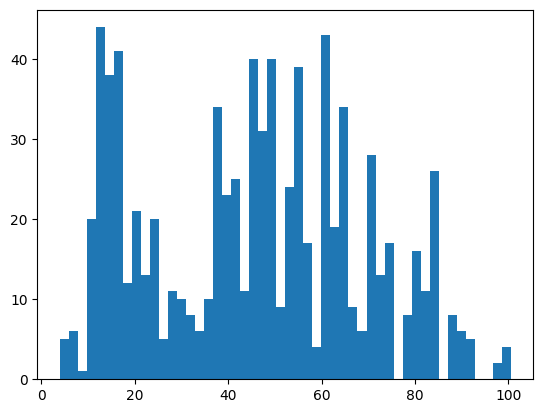

In [5]:
plt.hist(y_train.cpu(), bins = 50)
len(y_train.cpu())

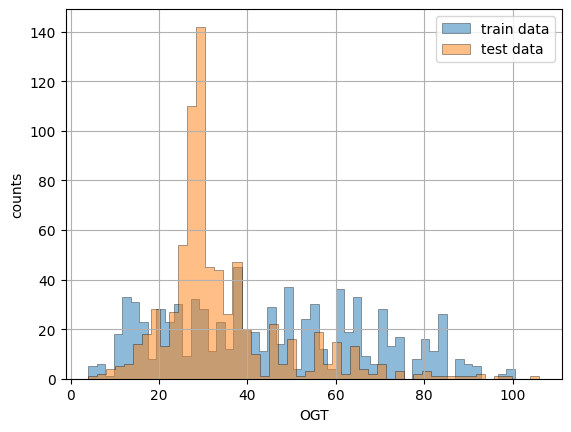

In [4]:
hist = plt.hist(y_train.cpu(), bins = 50, density = False, label = "train data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
hist = plt.hist(y_test.cpu(), bins = 50, density = False, label = "test data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();

## Initial prediction

In [13]:
from utils.utils import train_xgboost, calculate_aver_std
from sklearn.metrics import mean_squared_error,r2_score
from feature_selection.feature_selection_utils import xgboost_train_accur, xgboost_accur_select_features

model = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05).fit(X_train.cpu(), y_train.cpu())

# Define the baseline (for all features) XGBoost accuracy
y_true_cv, y_pred_cv, y_pred_test  = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), weights=None, model=model) 

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

XGBoost baseline test RMSE (all features) = 7.23, R2 = 0.74
XGBoost baseline CV RMSE (all features) = 7.45, R2 = 0.89


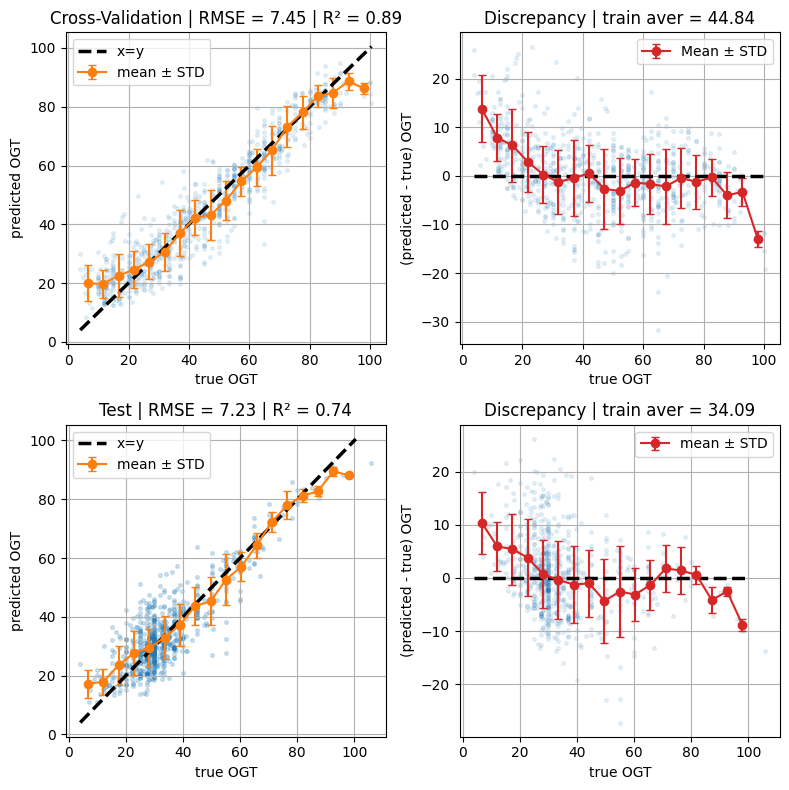

In [14]:
plt.figure(figsize=(8, 8))

num_bins = 20
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.legend()
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none') 
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)
plt.legend()

# Diff for full signal  
plt.subplot(2, 2, 4) 
y_test = y_test.cpu()
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()  
#plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

rmse_cv = 7.451746463775635; r2_cv = 0.892774760723114
rmse_test = 7.228456974029541; r2_test = 0.7435429096221924


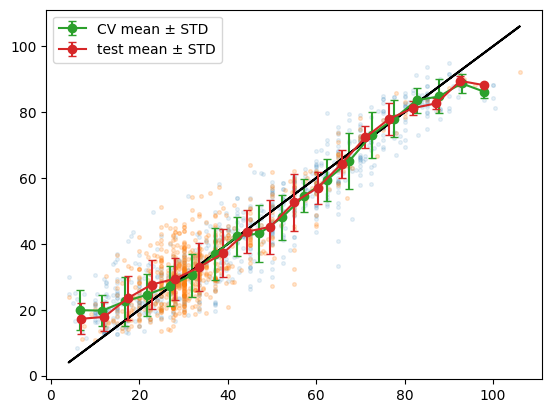

In [15]:
from utils.utils import train_xgboost, calculate_aver_std
from sklearn.metrics import mean_squared_error,r2_score
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05).fit(X_train.cpu(), y_train.cpu())
num_bins=20
#model = XGBRegressor(reg_alpha=1.0,reg_lambda=1.0, max_depth=3,subsample=0.8, colsample_bytree=0.8, n_estimators=100,learning_rate=0.05).fit(X_train.cpu(), y_train.cpu())

y_true_cv, y_pred_cv, y_pred_test  = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), weights=None, model=model) 

#y_true_cv = y_true_cv.flatten()
# y_pred_cv = y_pred_cv.flatten()

#X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
#preds = model.predict(X_train.cpu())
rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)
print(f"rmse_cv = {rmse_cv}; r2_cv = {r2_cv}")

plt.figure()
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:green', capsize=3, label='CV mean ± STD')

plt.plot(y_test.cpu(), y_test.cpu(), c="black")
#plt.scatter(y_true_cv, y_pred_cv, alpha= 0.1)



rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)
print(f"rmse_test = {rmse_test}; r2_test = {r2_test}")

plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:orange", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().flatten(), y_pred_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.legend()


## Step 2: Train Models on Data Segments

low_q = 31.0; high_q = 55.0
num low = 269; num mid = 255; num high = 293;


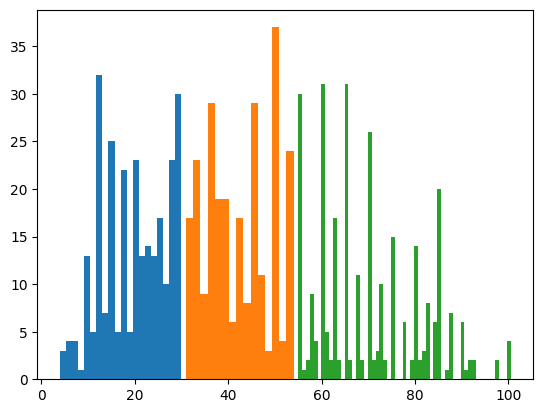

In [16]:
#y_train_log = np.log1p(y_train)
#y_test_log = np.log1p(y_test)

# Flatten y_train to 1D
y_train_flat = y_train.cpu().flatten()

# Compute quantiles from the flattened version
low_q = np.quantile(y_train_flat, 1/3)
high_q = np.quantile(y_train_flat, 2/3)
print(f"low_q = {low_q}; high_q = {high_q}")

# Define masks (all 1D)
low_mask  = y_train_flat < low_q
mid_mask  = (y_train_flat >= low_q) & (y_train_flat < high_q)
high_mask = y_train_flat >= high_q

# Apply masks correctly
X_low, y_low   = X_train[low_mask], y_train_flat[low_mask]
X_mid, y_mid   = X_train[mid_mask], y_train_flat[mid_mask]
X_high, y_high = X_train[high_mask], y_train_flat[high_mask]

plt.hist(y_low, bins=20)
plt.hist(y_mid, bins=15)
plt.hist(y_high, bins=55)

print(f"num low = {len(y_low)}; num mid = {len(y_mid)}; num high = {len(y_high)};")

In [10]:
high_q

33.5

In [35]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

model = XGBRegressor(reg_alpha=1.0,reg_lambda=1.0, max_depth=3,subsample=0.8, colsample_bytree=0.8, n_estimators=300,learning_rate=0.05)

model_low  = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05).fit(X_low, y_low)
model_mid  =  XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05).fit(X_mid, y_mid)
model_high =  XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05).fit(X_high, y_high)

In [36]:
def evaluate_model(model, X_test, y_test, segment_name):
    preds = model.predict(X_test)

    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)

    print(f"\nPerformance on {segment_name} segment:")
    print(f"  R²   : {r2:.3f}")
    print(f"  MAE  : {mae:.3f}")
    print(f"  RMSE : {rmse:.3f}")
    return r2, mae, rmse

In [37]:
# Optionally: split y_test the same way as y_train
y_test_flat = y_test.flatten()
# low_q = np.quantile(y_train.flatten(), 1/3)
# high_q = np.quantile(y_train.flatten(), 2/3)

# Create test masks
low_mask_test  = y_test_flat < low_q
mid_mask_test  = (y_test_flat >= low_q) & (y_test_flat < high_q)
high_mask_test = y_test_flat >= high_q

# Test splits
X_test_low, y_test_low   = X_test[low_mask_test], y_test_flat[low_mask_test]
X_test_mid, y_test_mid   = X_test[mid_mask_test], y_test_flat[mid_mask_test]
X_test_high, y_test_high = X_test[high_mask_test], y_test_flat[high_mask_test]

In [38]:
# Evaluate each model
evaluate_model(model_low,  X_test_low,  y_test_low,  "Low")
evaluate_model(model_mid,  X_test_mid,  y_test_mid,  "Mid")
evaluate_model(model_high, X_test_high, y_test_high, "High")


Performance on Low segment:
  R²   : -0.765
  MAE  : 5.804
  RMSE : 6.766

Performance on Mid segment:
  R²   : -0.020
  MAE  : 4.772
  RMSE : 5.747

Performance on High segment:
  R²   : 0.817
  MAE  : 3.871
  RMSE : 4.995


C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(0.8167281746864319, 3.8714406, 4.9948025)

In [39]:
gain_dict = model_low.get_booster().get_score(importance_type='gain')
total_gain = sum(gain_dict.values()) / len(y_low)
print(f"Tot gain in low model = {total_gain}")

gain_dict = model_mid.get_booster().get_score(importance_type='gain')
total_gain = sum(gain_dict.values()) / len(y_mid)
print(f"Tot gain in mid model = {total_gain}")

gain_dict = model_high.get_booster().get_score(importance_type='gain')
total_gain = sum(gain_dict.values()) / len(y_high)
print(f"Tot gain in high model = {total_gain}")

Tot gain in low model = 146.25350452067684
Tot gain in mid model = 132.2250809954662
Tot gain in high model = 201.55693972395548


## Step 3: Normalize Sensitivity via Target Transform or Weights


### Log-Transforming Target

In [17]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Define the baseline (for all features) XGBoost accuracy
y_true_cv, y_pred_cv, y_pred_test  = train_xgboost(X_train.cpu(), y_train_log.cpu(), X_test.cpu(), y_test_log.cpu(), weights=None) 

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

XGBoost baseline test RMSE (all features) = 38.27, R2 = -3.44
XGBoost baseline CV RMSE (all features) = 0.23, R2 = 0.79


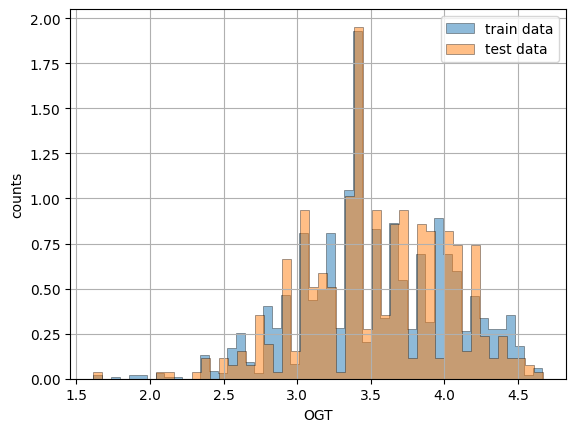

In [18]:
hist = plt.hist(y_train_log.cpu(), bins = 50, density = True, label = "train data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
hist = plt.hist(y_test_log.cpu(), bins = 50, density = True, label = "test data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();

In [13]:
y_true_cv = np.expm1(y_true_cv)
y_pred_cv = np.expm1(y_pred_cv)
y_pred_test = np.expm1(y_pred_test)

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

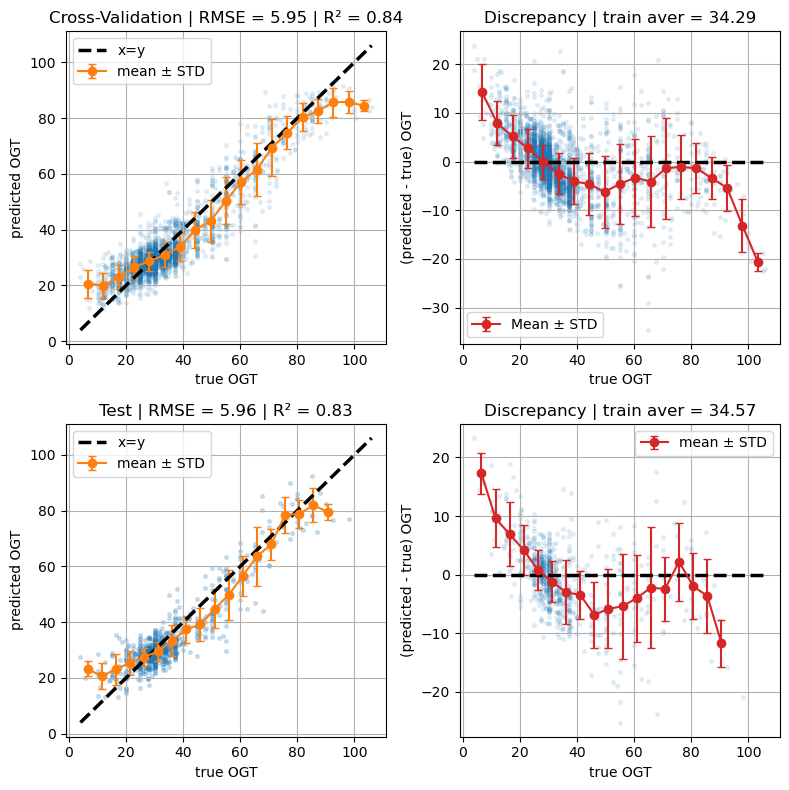

In [14]:
plt.figure(figsize=(8, 8))

num_bins = 20
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.legend()
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none') 
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)
plt.legend()

# Diff for full signal  
plt.subplot(2, 2, 4) 
y_test = y_test.cpu()
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()  
#plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

### Weighting Samples

In [14]:
from utils.utils import train_xgboost
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from utils.utils import train_xgboost, calculate_aver_std

weights = np.ones(len(y_train))
weights[y_train.squeeze() < low_q] = 1   # Upweight low tail
weights[y_train.squeeze() > high_q] = 0 # Downweight long tail

# Define the baseline (for all features) XGBoost accuracy
y_true_cv, y_pred_cv, y_pred_test  = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), weights=weights) 

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:723: FutureWarning: Pass `sample_weight` as keyword args.
  warnings.warn(msg, FutureWarning)


XGBoost baseline test RMSE (all features) = 15.40, R2 = -0.14
XGBoost baseline CV RMSE (all features) = 15.58, R2 = -0.10


In [15]:
low_q

28.0

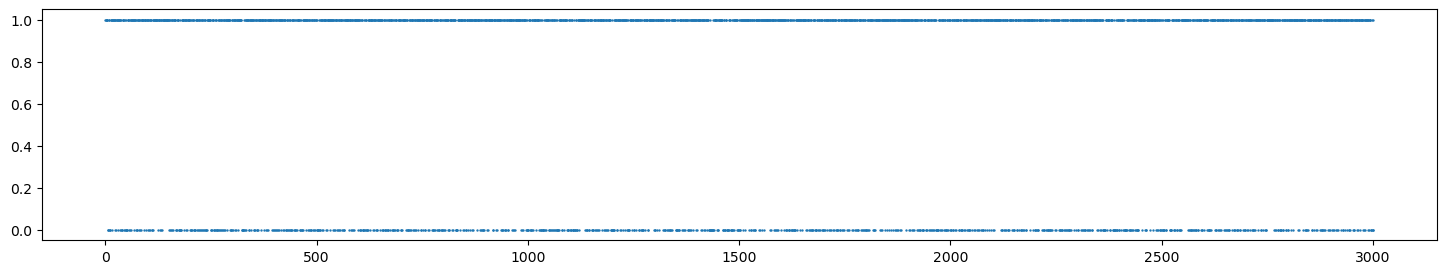

In [16]:
plt.figure(figsize=(18, 3))
plt.scatter(range(len(weights)), weights, s=0.5)

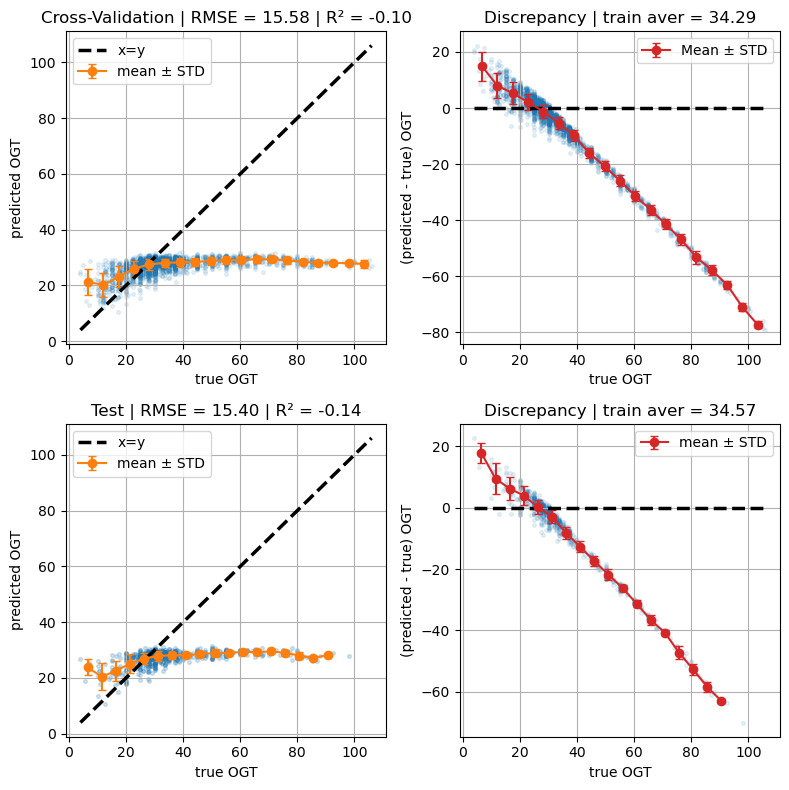

In [17]:
plt.figure(figsize=(8, 8))

num_bins = 20
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.legend()
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none') 
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)
plt.legend()

# Diff for full signal  
plt.subplot(2, 2, 4) 
y_test = y_test.cpu()
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.show()

### Test Generalization Between Segments

In [16]:
y_low[:10]
preds

NameError: name 'preds' is not defined

In [22]:
preds = model_low.predict(X_low)
preds[:10]

array([23.6208  , 25.35663 , 25.27836 , 20.841986, 25.772318, 24.84976 ,
       19.884983, 26.390766, 25.685076, 19.68506 ], dtype=float32)

In [54]:
# y_low = np.expm1(y_low)
# y_mid = np.expm1(y_mid)
# y_high = np.expm1(y_high)


In [56]:
# y_test_low = np.expm1(y_test_low)
# y_test_mid = np.expm1(y_test_mid)
# y_test_high = np.expm1(y_test_high)

In [44]:
preds = model_low.predict(X_mid)
preds_test = model_low.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test =  r2_score(y_test_mid, preds_test)
r2_test

-23.651071548461914

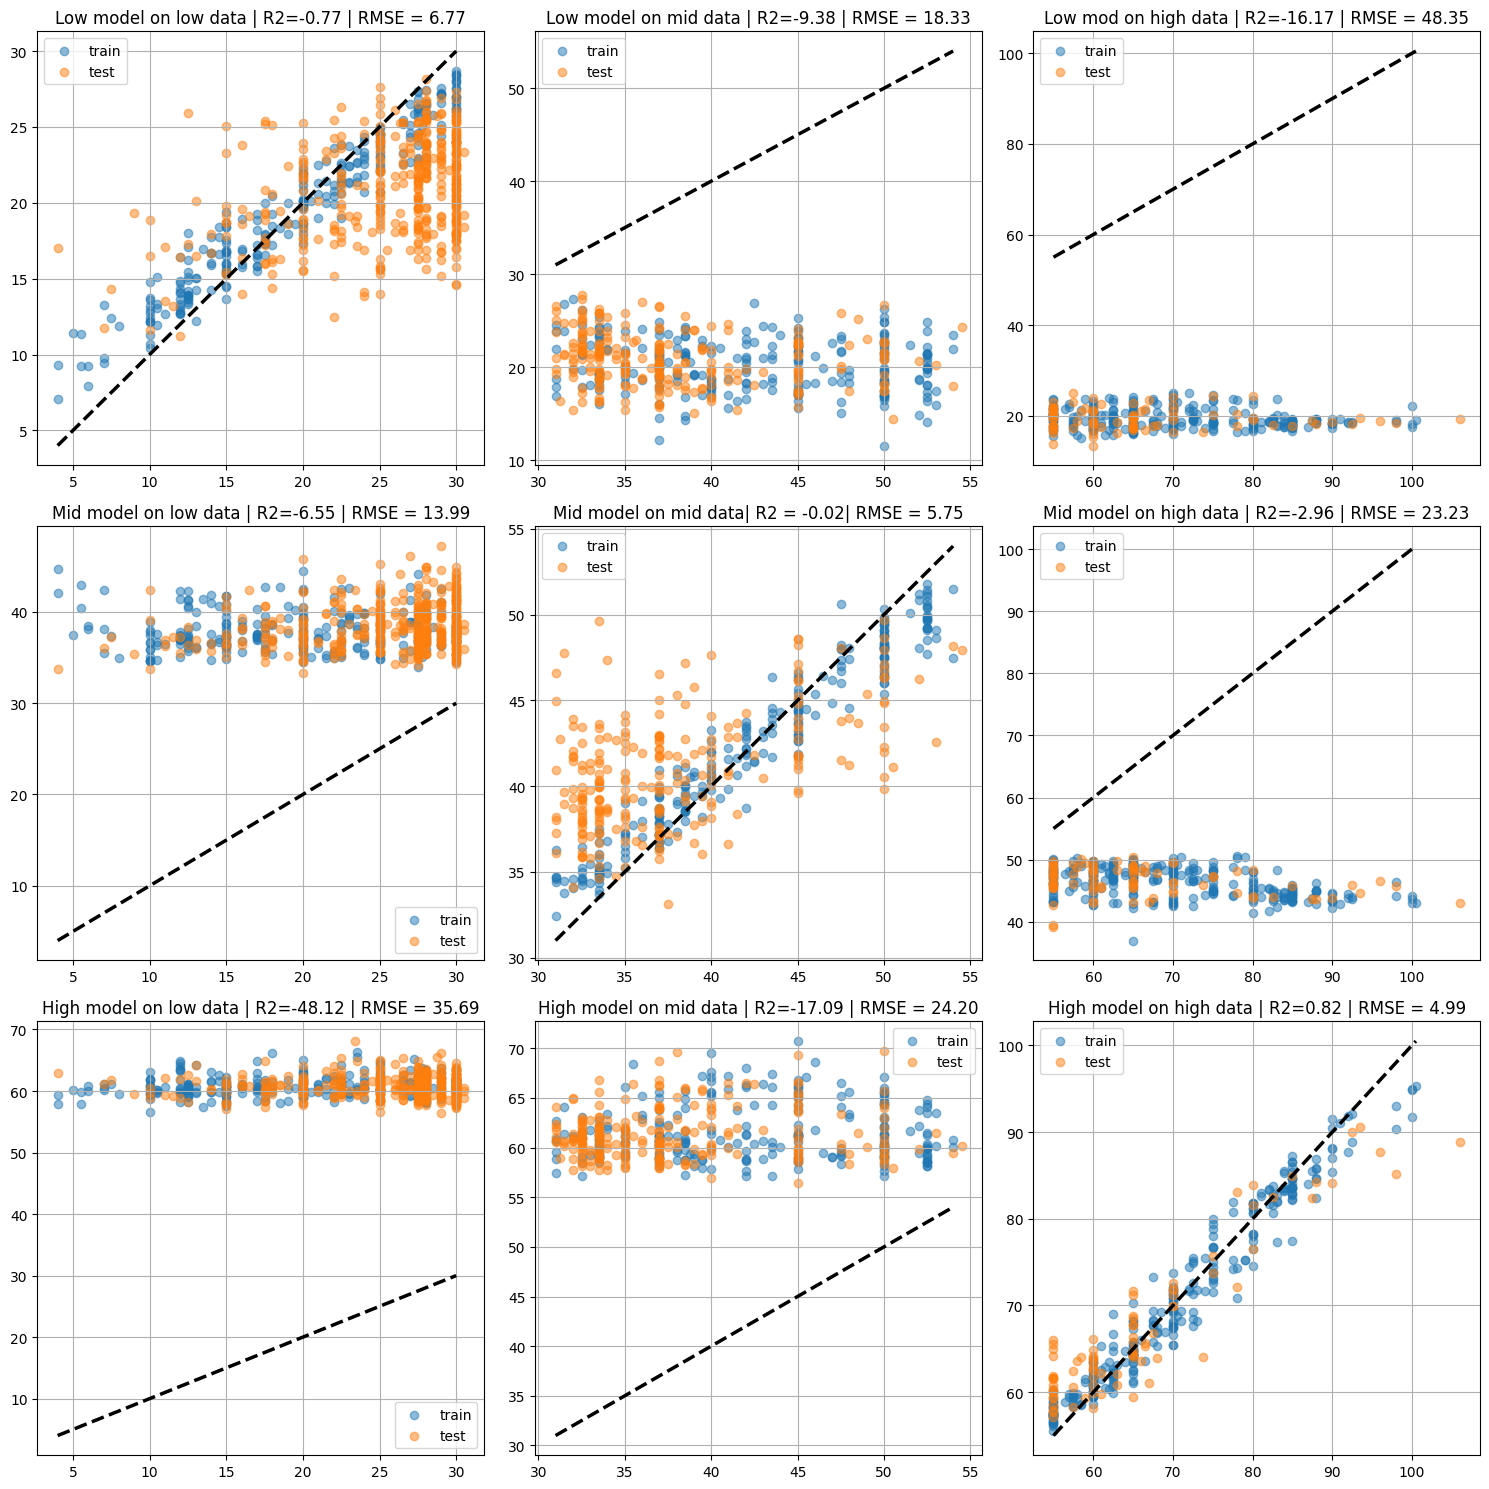

In [46]:
plt.figure(figsize=(15, 15))

plt.subplot(3, 3, 1) 
preds = model_low.predict(X_low)
plt.scatter(y_low, preds, alpha = 0.5, label = "train")
preds_test = model_low.predict(X_test_low)
rmse_test = np.sqrt(mean_squared_error(y_test_low, preds_test))
r2_test =  r2_score(y_test_low, preds_test)
plt.scatter(y_test_low.flatten(), preds_test, alpha = 0.5, label = "test")
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Low model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 2) 
preds = model_low.predict(X_mid)
preds_test = model_low.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test =  r2_score(y_test_mid, preds_test)
plt.scatter(y_mid, preds, alpha = 0.5, label = "train")
plt.scatter(y_test_mid.flatten(), preds_test, alpha = 0.5, label = "test")
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Low model on mid data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 3) 
preds = model_low.predict(X_high)
preds_test = model_low.predict(X_test_high)
rmse_test = np.sqrt(mean_squared_error(y_test_high, preds_test))
r2_test = r2_score(y_test_high, preds_test)
plt.scatter(y_high, preds, alpha = 0.5, label = "train")
plt.scatter(y_test_high.flatten(), model_low.predict(X_test_high), alpha = 0.5, label = "test")
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Low mod on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 4) 
preds = model_mid.predict(X_low)
preds_test = model_mid.predict(X_test_low)
rmse_test = np.sqrt(mean_squared_error(y_test_low, preds_test))
r2_test = r2_score(y_test_low, preds_test)
plt.scatter(y_low, preds, alpha = 0.5, label = "train")
plt.scatter(y_test_low.flatten(), model_mid.predict(X_test_low), alpha = 0.5, label = "test")
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Mid model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 5) 
preds = model_mid.predict(X_mid)
preds_test = model_mid.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test = r2_score(y_test_mid, preds_test)
plt.scatter(y_mid, preds, alpha = 0.5, label = "train")
plt.scatter(y_test_mid.flatten(), model_mid.predict(X_test_mid), alpha = 0.5, label = "test")
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Mid model on mid data| R2 = {r2_test:.2f}| RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 6) 
preds = model_mid.predict(X_high)
preds_test = model_mid.predict(X_test_high)
rmse_test = np.sqrt(mean_squared_error(y_test_high, preds_test))
r2_test = r2_score(y_test_high, preds_test)
plt.scatter(y_high, preds, alpha = 0.5, label = "train")
plt.scatter(y_test_high.flatten(), model_mid.predict(X_test_high), alpha = 0.5, label = "test")
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Mid model on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 7) 
preds = model_high.predict(X_low)
preds_test = model_high.predict(X_test_low)
rmse_test = np.sqrt(mean_squared_error(y_test_low, preds_test))
r2_test = r2_score(y_test_low, preds_test)
plt.scatter(y_low, preds, alpha = 0.5, label = "train")
plt.scatter(y_test_low.flatten(), model_high.predict(X_test_low), alpha = 0.5, label = "test")
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"High model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 8) 
preds = model_high.predict(X_mid)
preds_test = model_high.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test = r2_score(y_test_mid, preds_test)
plt.scatter(y_mid, preds, alpha = 0.5, label = "train")
plt.scatter(y_test_mid.flatten(), model_high.predict(X_test_mid), alpha = 0.5, label = "test")
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"High model on mid data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 9) 
preds = model_high.predict(X_high)
preds_test = model_high.predict(X_test_high)
rmse_test = np.sqrt(mean_squared_error(y_test_high.flatten(), preds_test))
r2_test = r2_score(y_test_high.flatten(), preds_test)
plt.scatter(y_high, preds, alpha = 0.5, label = "train")
plt.scatter(y_test_high.flatten(), model_high.predict(X_test_high), alpha = 0.5, label = "test")
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"High model on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)

plt.tight_layout()

In [44]:
rmse_test = np.sqrt(mean_squared_error(y_test_high.flatten(), preds_test))
y_test_high.flatten()

tensor([ 55.0000,  70.0000,  68.0000,  70.0000,  61.0000,  65.0000,  75.0000,
         55.0000,  58.5000,  55.0000,  85.0000,  80.0000,  63.0000,  55.0000,
         70.0000,  65.0000,  65.0000,  92.5000,  65.0000,  65.0000,  75.0000,
         57.5000,  65.0000,  60.0000,  66.5000,  87.5000,  65.0000,  65.0000,
         60.0000,  63.0000,  88.0000,  60.0000,  78.0000,  60.0000,  60.0000,
         70.0000, 106.0000,  80.0000,  55.0000,  61.0000,  55.0000,  67.5000,
         60.0000,  70.0000,  60.0000,  65.0000,  55.0000,  55.0000,  55.0000,
         55.0000,  66.0000,  55.0000,  90.0000,  55.0000,  93.5000,  82.5000,
         60.0000,  65.0000,  66.5000,  55.0000,  96.0000,  55.0000,  60.0000,
         73.7500,  67.0000,  55.0000,  55.0000,  65.0000,  70.0000,  59.0000,
         60.0000,  58.0000,  55.0000,  57.5000,  80.0000,  65.0000,  60.0000,
         78.0000,  55.0000,  98.0000,  57.5000,  55.0000,  60.0000,  60.0000,
         65.0000])

In [45]:
preds_test

array([20.950802, 16.38699 , 17.901562, 20.002369, 22.644514, 18.399143,
       24.41452 , 20.224846, 20.817213, 18.012907, 17.84097 , 19.530651,
       18.69564 , 17.807138, 19.026072, 19.84941 , 17.248165, 18.164268,
       20.153627, 19.46568 , 20.117142, 23.048092, 22.903336, 18.687984,
       21.472334, 18.86089 , 19.572348, 17.628777, 21.33745 , 16.25778 ,
       18.25738 , 18.552498, 20.303951, 21.062202, 20.889841, 24.108276,
       19.17922 , 19.102001, 19.520498, 17.55997 , 16.796124, 17.83459 ,
       17.062977, 22.47972 , 15.964989, 17.371206, 22.940733, 17.142338,
       22.006357, 19.362398, 21.041834, 20.641148, 18.537   , 21.41995 ,
       19.555195, 17.981716, 19.371874, 16.801044, 16.754814, 21.79339 ,
       18.877054, 17.753548, 18.148361, 16.30684 , 23.49551 , 20.574594,
       21.700272, 17.992468, 21.108316, 21.767187, 23.98199 , 18.77506 ,
       20.112827, 17.224653, 24.318249, 17.196655, 15.284012, 17.794113,
       16.135479, 18.385748, 25.052837, 13.685175, 

### Top important features

Top 10 most important features by gain in the low model:
K16291: 868.31
K01589: 825.26
K10778: 740.54
K03547: 689.66
K03315: 646.25
K07032: 571.30
K13583: 540.03
K02046: 514.61
K09942: 506.79
K07141: 505.08


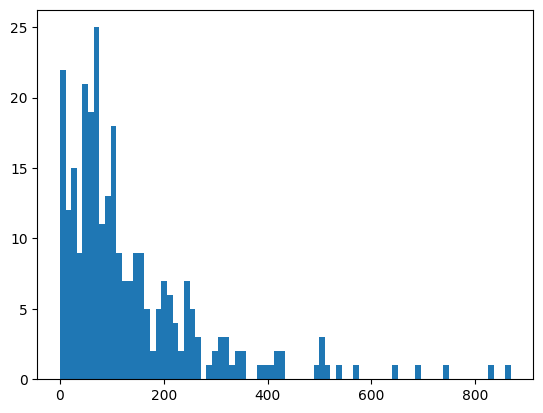

In [47]:
# Get feature importance scores (by gain)
gain_dict = model_low.get_booster().get_score(importance_type='gain')

# Sort features by gain, descending
sorted_gain = sorted(gain_dict.items(), key=lambda item: item[1], reverse=True)

# Extract top 10 features
top_10 = sorted_gain[:10]

# Display nicely
print("Top 10 most important features by gain in the low model:")
feature_map = dict(zip([f"f{i}" for i in range(X_train.shape[1])], X_column_names))
for f, score in top_10:
    print(f"{feature_map[f]}: {score:.2f}")

gain_scores = list(gain_dict.values())
plt.hist(gain_scores, bins=80);

Top 10 most important features by gain in the mid model:
K15342: 1023.22
K19091: 910.14
K06208: 567.92
K02407: 565.23
K01246: 551.16
K09954: 545.15
K00336: 527.76
K00260: 477.02
K09706: 446.20
K06384: 403.04


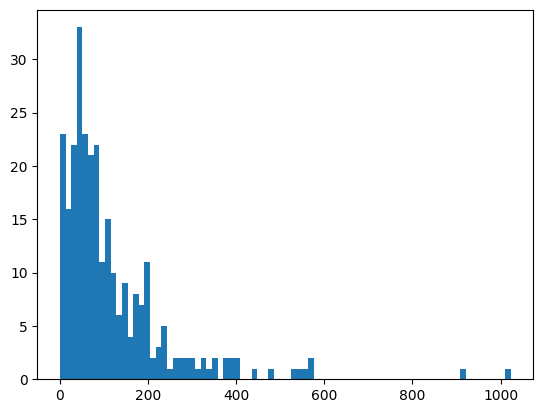

In [48]:
# Get feature importance scores (by gain)
gain_dict = model_mid.get_booster().get_score(importance_type='gain')

# Sort features by gain, descending
sorted_gain = sorted(gain_dict.items(), key=lambda item: item[1], reverse=True)

# Extract top 10 features
top_10 = sorted_gain[:10]

# Display nicely
print("Top 10 most important features by gain in the mid model:")
feature_map = dict(zip([f"f{i}" for i in range(X_train.shape[1])], X_column_names))
for f, score in top_10:
    print(f"{feature_map[f]}: {score:.2f}")

gain_scores = list(gain_dict.values())
plt.hist(gain_scores, bins=80);

Top 10 most important features by gain in the high model:
K04043: 12074.51
K06870: 5361.96
K03551: 2661.83
K03170: 1679.83
K05716: 1166.07
K03724: 791.04
K08482: 773.49
K04070: 687.14
K07658: 661.19
K07007: 655.17


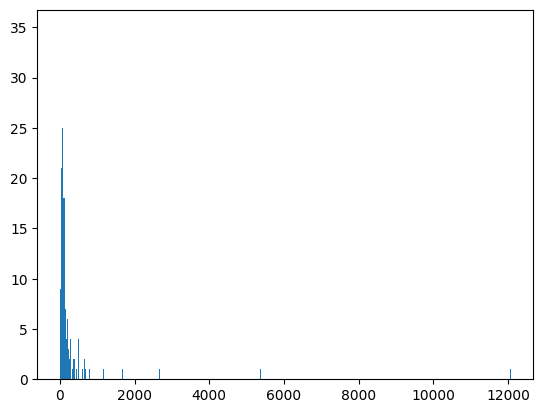

In [49]:
# Get feature importance scores (by gain)
gain_dict = model_high.get_booster().get_score(importance_type='gain')

# Sort features by gain, descending
sorted_gain = sorted(gain_dict.items(), key=lambda item: item[1], reverse=True)

# Extract top 10 features
top_10 = sorted_gain[:10]

# Display nicely
print("Top 10 most important features by gain in the high model:")
feature_map = dict(zip([f"f{i}" for i in range(X_train.shape[1])], X_column_names))
for f, score in top_10:
    print(f"{feature_map[f]}: {score:.2f}")

gain_scores = list(gain_dict.values())
plt.hist(gain_scores, bins=800);

### Vizualization 

Shape of the projected data = (3002, 2)


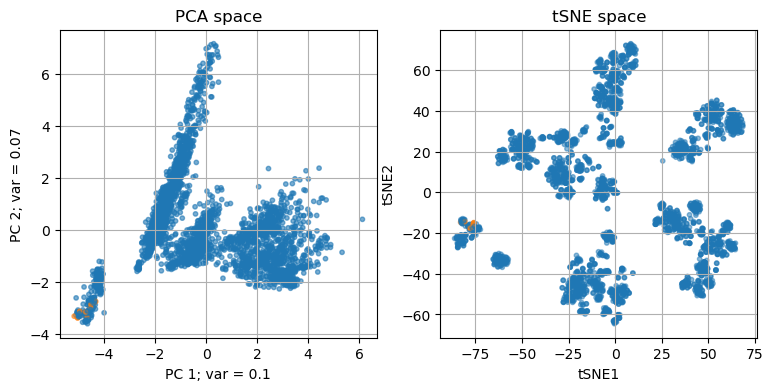

In [51]:
from utils.utils import pca_run_and_plot, tsne_plot
from matplotlib.colors import ListedColormap

y_train_masked = [5 if yi>90  else 0 for yi in y_train]

colors = ListedColormap(["tab:blue", "tab:orange"])
plt.figure(figsize=(9, 4))
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_train, n_compon, y_train_masked, None, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train, 50, 100, RANDOM_SEED, y_train_masked, colors);

Shape of the projected data = (3002, 2)


Text(0.5, 0.98, 'Expression level of K05794')

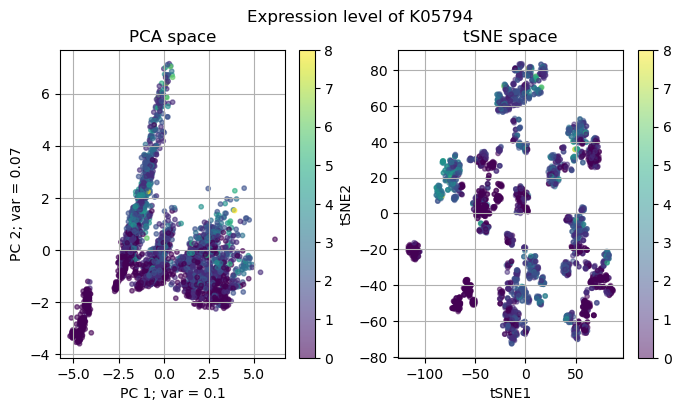

In [59]:
feature_name = 'K05794'
X_column_names = list(X_column_names)

if feature_name in X_column_names:
    idx = X_column_names.index(feature_name)
else:
    print(f"This feature doesn't exist in the feature space!")

feature_expression = X_train[:, idx]
feature_expression = feature_expression.cpu()

from matplotlib import cm
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colorbar = True
colors = ListedColormap(cm.viridis(np.linspace(0, 1, len(feature_expression))))
pca_run_and_plot(X_train.cpu(), n_compon, feature_expression, None, colors, legend = False, colorbar = colorbar);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train.cpu(), 30, 100, RANDOM_SEED, feature_expression, colors, colorbar = colorbar);
plt.suptitle(f"Expression level of {feature_name}")

In [58]:
max(feature_expression)


tensor(3, dtype=torch.int32)

### Sliding window stuff

In [50]:
y_train_flat = y_train.flatten().cpu()
y_test_flat = y_test.flatten().cpu()

504
583
601
593
551
404
203
140
116
92
78
55
40
23


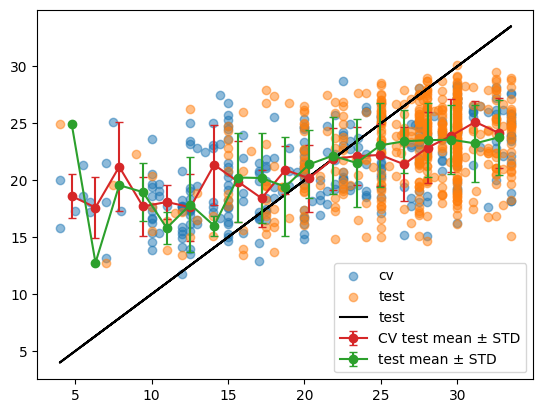

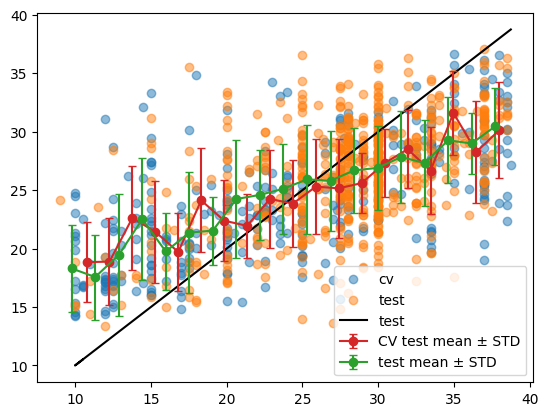

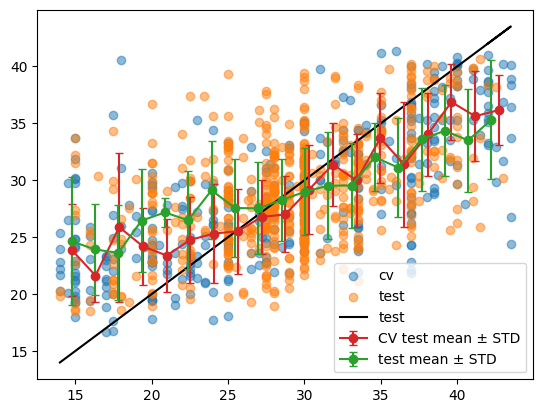

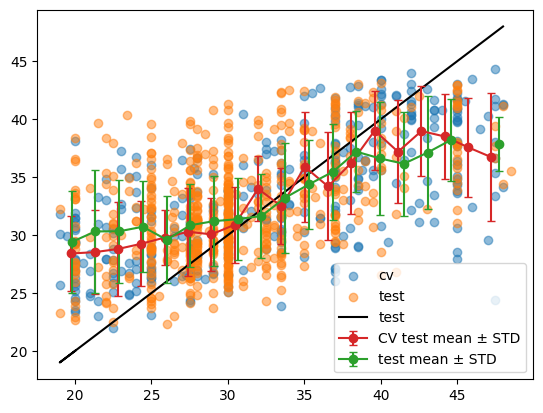

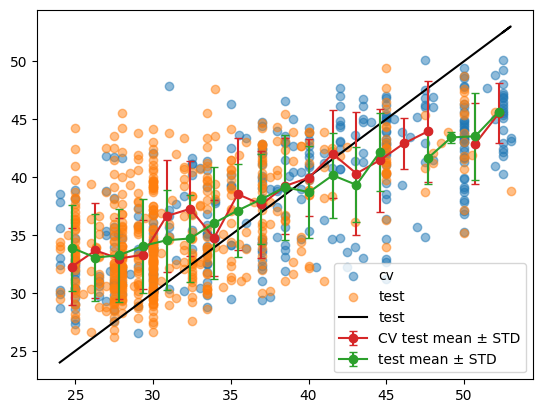

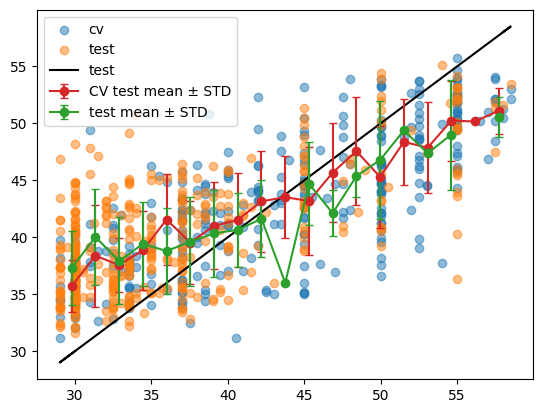

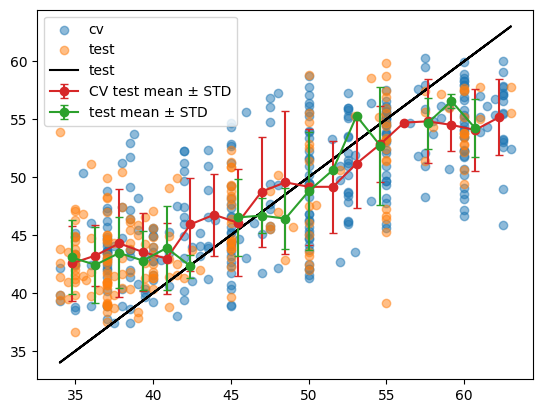

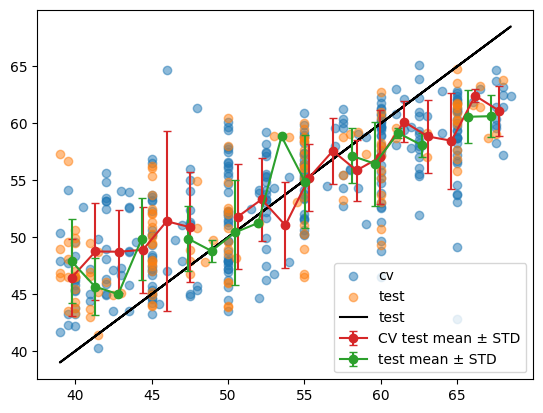

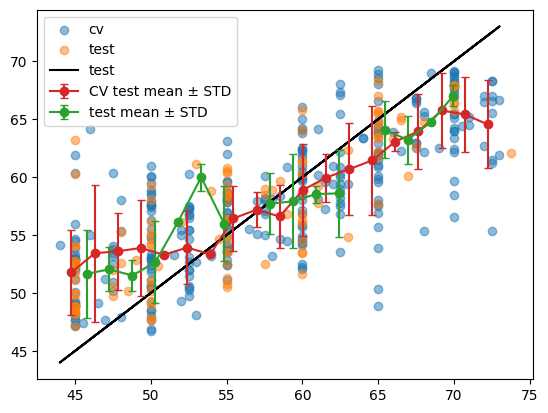

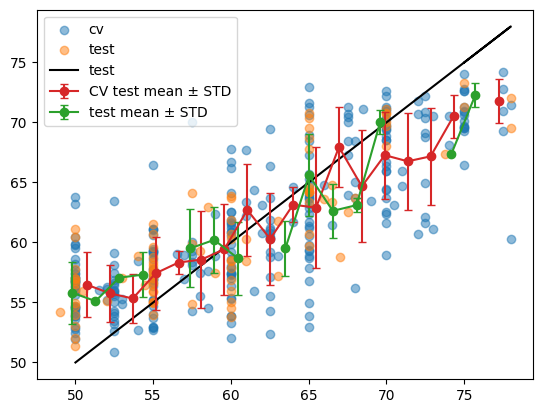

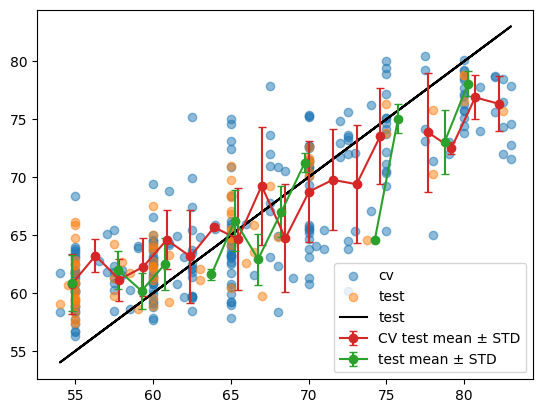

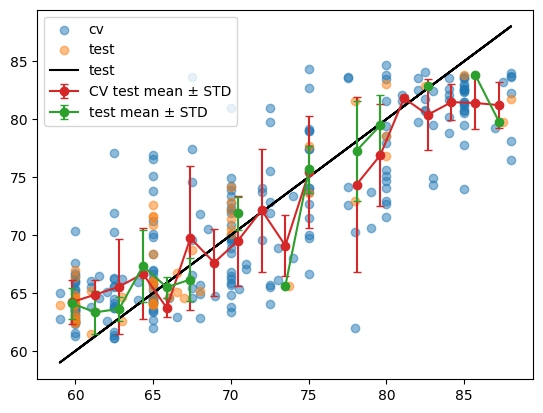

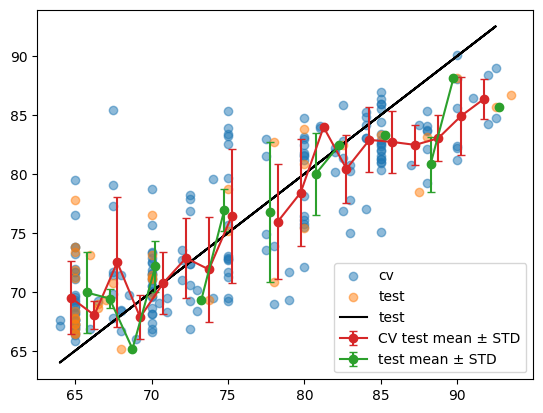

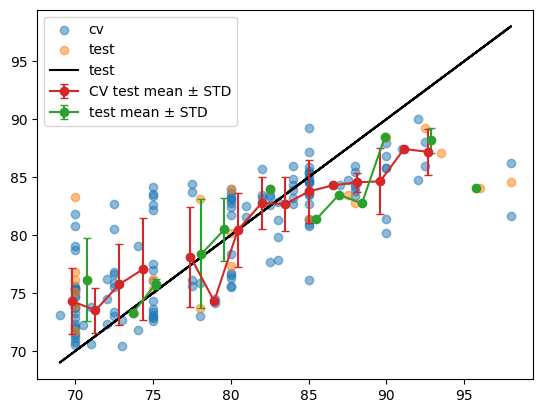

In [53]:
model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05).fit(X_train.cpu(), y_train.cpu())
#XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05).fit(X_high, y_high)

min_val = min(y_train_flat).cpu().item()
max_val = max(y_train_flat).cpu().item()
window_size = 30
step_size = 5

windows = []
start = min_val
while start + window_size <= max_val:
    end = start + window_size
    windows.append((start, end))
    start += step_size

windiow_centers = []
r2_cv_arr = []
r2_test_arr = []
rmse_cv_arr = []
rmse_test_arr = []


#plt.figure()

for window in windows:
    windiow_centers.append(np.mean(window))
    
    mask_train  = (y_train_flat >= window[0]) & (y_train_flat < window[1])
    X_train_mask, y_train_mask   = X_train[mask_train], y_train_flat[mask_train]

    mask_test  = (y_test_flat >= window[0]) & (y_test_flat < window[1])
    X_test_mask, y_test_mask = X_test[mask_test], y_test_flat[mask_test]

    y_true_cv, y_pred_cv, y_pred_test  = train_xgboost(X_train_mask.cpu(), y_train_mask.cpu(), X_test_mask.cpu(), y_test_mask.cpu(), weights=None, model=model) 

    r2_cv = r2_score(y_true_cv, y_pred_cv)
    rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
    r2_cv_arr.append(r2_cv)
    rmse_cv_arr.append(rmse_cv)

    rmse_test = np.sqrt(mean_squared_error(y_test_mask.cpu(), y_pred_test))
    r2_test = r2_score(y_test_mask.cpu(), y_pred_test)
    if len(y_test_mask) > 40:
        r2_test_arr.append(r2_test)
        rmse_test_arr.append(rmse_test)
    else:
        r2_test_arr.append(None)
        rmse_test_arr.append(None)

    print(len(y_test_mask))

    plt.figure()
    plt.scatter(y_true_cv, y_pred_cv, label="cv", alpha=0.5)
    plt.scatter(y_test_mask, y_pred_test, label="test", alpha=0.5)
    plt.plot(y_true_cv, y_true_cv, label="test", c="black")
    
    bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv, y_pred_cv, num_bins)
    plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='CV test mean ± STD')
    
    bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_mask, y_pred_test, num_bins)
    plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:green', capsize=3, label='test mean ± STD')
    plt.legend()
    

In [75]:
rmse_test_arr

[3.6134365,
 3.8625925,
 3.913023,
 3.952363,
 3.5756736,
 3.9317477,
 4.164081,
 4.472642,
 4.430765,
 4.278433,
 3.8153756,
 3.8656995,
 3.8282123,
 4.5476923,
 None,
 None,
 None]

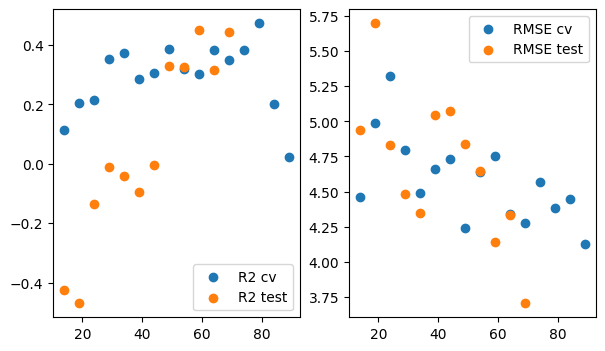

In [52]:
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.scatter(windiow_centers, r2_cv_arr, label = "R2 cv")
plt.scatter(windiow_centers, r2_test_arr, label = "R2 test")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(windiow_centers, rmse_cv_arr, label = "RMSE cv")
plt.scatter(windiow_centers, rmse_test_arr, label = "RMSE test")
plt.legend()

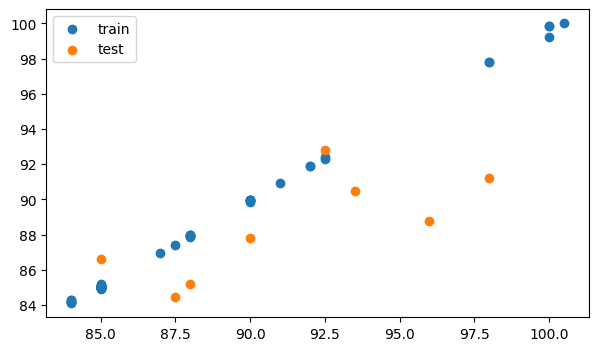

In [63]:
plt.figure(figsize=(7, 4))

preds = model_on_mask.predict(X_train_mask)
rmse_train = np.sqrt(mean_squared_error(y_train_mask, preds))
plt.scatter(y_train_mask, preds, label="train")
r2_train = r2_score(y_train_mask, preds)
r2_train_arr.append(r2_train)
rmse_train_arr.append(rmse_train)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_train_mask.cpu().squeeze(),preds, num_bins)
#plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')

mask_test  = (y_test_flat >= window[0]) & (y_test_flat < window[1])
X_test_mask, y_test_mask = X_test[mask_test], y_test_flat[mask_test]

preds = model_on_mask.predict(X_test_mask)
rmse_test = np.sqrt(mean_squared_error(y_test_mask, preds))
plt.scatter(y_test_mask, preds, label="test")
r2_test = r2_score(y_test_mask, preds)
r2_test_arr.append(r2_test)
rmse_test_arr.append(rmse_test)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_mask.cpu().squeeze(),preds, num_bins)
#plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.legend()
